In [1]:
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import time

In [2]:
#Clubs all transforms together
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])
input_size = 784
hidden_layer_size = 300
output_size = 10
losses = []
accuracies = []

In [3]:
class MyNeuralModel():
    def __init__(self, sizes, epochs=20, alpha=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.alpha = alpha
        self.init_params()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exes = np.exp(x)
        deno = np.sum(exes, axis=1)
        deno.resize(exes.shape[0], 1)
        return exes / deno

    def init_params(self):
        input_layer = int(self.sizes[0])
        hidden_1 = int(self.sizes[1])
        hidden_2 = int(self.sizes[2])
        output_layer = int(self.sizes[3])
        # Random initialization of weights between -1 and 1
        self.w1 = np.random.uniform(low=-1, high=1, size=(input_layer, hidden_1))
        self.w2 = np.random.uniform(low=-1, high=1, size=(hidden_1, hidden_2))
        self.w3 = np.random.uniform(low=-1, high=1, size=(hidden_2, output_layer))
        # Zero initialization of weights
        # self.w1 = np.zeros((input_layer, hidden_1))
        # self.w2 = np.zeros((hidden_1, hidden_2))
        # self.w2 = np.zeros((hidden_,2 output_layer))

    def forward(self, inputs):
        inputs = inputs.numpy()
        self.linear_1 = inputs.dot(self.w1)
        self.out1 = self.sigmoid(self.linear_1)
        self.linear_2 = self.out1.dot(self.w2)
        self.out2 = self.sigmoid(self.linear_2)
        self.linear3=self.out2.dot(self.w3)
        self.out3 = self.softmax(self.linear3)
        return self.out3

    def backward(self, x_train, y_train, output):
        x_train = x_train.numpy()
        y_train = y_train.numpy()
        batch_size = y_train.shape[0]
        d_loss = output - y_train
        delta_w3 = (1. / batch_size) * np.matmul(self.out2.T, d_loss)
        d_out_1 = np.matmul(d_loss, self.w3.T)
        d_linear_2 = d_out_1 * self.sigmoid(self.linear_2) * (1 - self.sigmoid(self.linear_2))
        delta_w2 = (1. / batch_size) * np.matmul(self.out1.T, d_linear_2)
        d_out_2 = np.matmul(d_linear_2, self.w2.T)
        d_linear_1 = d_out_2 * self.sigmoid(self.linear_1) * (1 - self.sigmoid(self.linear_1))
        delta_w1 = (1. / batch_size) * np.matmul(x_train.T, d_linear_1)
        return delta_w1, delta_w2 ,delta_w3

    def update_weights(self, w1_update, w2_update,w3_update):
        self.w1 -= self.alpha * w1_update
        self.w2 -= self.alpha * w2_update
        self.w3 -=self.alpha * w3_update

    def calculate_loss(self, y, y_hat):
        batch_size = y.shape[0]
        y = y.numpy()
        loss = np.sum(np.multiply(y, np.log(y_hat)))
        loss = -(1. / batch_size) * loss
        return loss

    def calculate_metrics(self, data_loader):
        losses = []
        correct = 0
        total = 0

        for i, data in enumerate(data_loader):
            x, y = data
            y_onehot = torch.zeros(y.shape[0], 10)
            y_onehot[range(y_onehot.shape[0]), y] = 1
            flattened_input = x.view(-1, 28 * 28)
            output = self.forward(flattened_input)
            predicted = np.argmax(output, axis=1)
            correct += np.sum((predicted == y.numpy()))
            total += y.shape[0]
            loss = self.calculate_loss(y_onehot, output)
            losses.append(loss)
        return (correct / total), np.mean(np.array(losses))

    def train(self, train_loader, data_loader):
        start_time = time.time()
        global losses, accuracies
        for iteration in range(self.epochs):
            for i, data in enumerate(train_loader):
                x, y = data
                y_onehot = torch.zeros(y.shape[0], 10)
                y_onehot[range(y_onehot.shape[0]), y] = 1
                flat_input = x.view(-1, 28 * 28)
                output = self.forward(flat_input)
                w1_update, w2_update, w3_update = self.backward(flat_input, y_onehot, output)
                self.update_weights(w1_update, w2_update,w3_update)
            accuracy, loss = self.calculate_metrics(data_loader)
            losses.append(loss)
            accuracies.append(accuracy)
            print('Epoch: {0}, Test Error Percent: {1:.2f}, Loss: {2:.2f}'.format(
                iteration + 1, 100 - accuracy * 100, loss
            ))




In [4]:
model = MyNeuralModel(sizes=[784, 300, 200, 10], epochs=50)
batchsize=32
trainset = datasets.MNIST('./dataset/MNIST/', download=True, train=True, transform=transform)
testset = datasets.MNIST('./dataset/MNIST/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
dataloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/MNIST/raw



In [5]:
examples = enumerate(testset)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([1, 28, 28])


([], [])

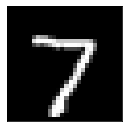

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.subplot(2,3,1)
plt.tight_layout()
plt.imshow(example_data[0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])


#Question 3
##Part 2
α=0.01, \\
BatchSize = 32, \\
Epochs = 50, \\
Initialised randomly between -1 and 1


Epoch: 1, Test Error Percent: 27.56, Loss: 0.85
Epoch: 2, Test Error Percent: 20.15, Loss: 0.63
Epoch: 3, Test Error Percent: 17.00, Loss: 0.54
Epoch: 4, Test Error Percent: 14.87, Loss: 0.49
Epoch: 5, Test Error Percent: 13.61, Loss: 0.45
Epoch: 6, Test Error Percent: 12.80, Loss: 0.42
Epoch: 7, Test Error Percent: 12.18, Loss: 0.40
Epoch: 8, Test Error Percent: 11.68, Loss: 0.39
Epoch: 9, Test Error Percent: 11.29, Loss: 0.37
Epoch: 10, Test Error Percent: 10.82, Loss: 0.36
Epoch: 11, Test Error Percent: 10.54, Loss: 0.35
Epoch: 12, Test Error Percent: 10.41, Loss: 0.34
Epoch: 13, Test Error Percent: 10.15, Loss: 0.33
Epoch: 14, Test Error Percent: 10.00, Loss: 0.32
Epoch: 15, Test Error Percent: 9.77, Loss: 0.31
Epoch: 16, Test Error Percent: 9.41, Loss: 0.31
Epoch: 17, Test Error Percent: 9.33, Loss: 0.30
Epoch: 18, Test Error Percent: 9.16, Loss: 0.30
Epoch: 19, Test Error Percent: 8.99, Loss: 0.29
Epoch: 20, Test Error Percent: 8.81, Loss: 0.29
Epoch: 21, Test Error Percent: 8.74

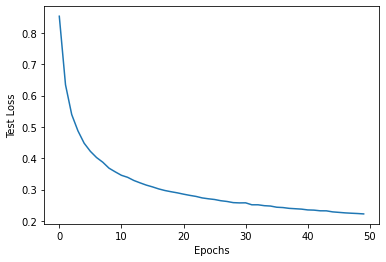

In [7]:
model.train(train_loader=trainloader, data_loader=dataloader)


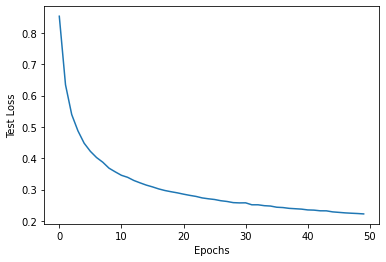

In [10]:
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.plot(losses)
plt.show()

##Part 2
α=0.01 \\
BatchSize=64 \\
Epochs = 50 \\



In [11]:
model = MyNeuralModel(sizes=[784, 300, 200, 10], epochs=50)
batchsize=64
trainset = datasets.MNIST('./dataset/MNIST/', download=True, train=True, transform=transform)
testset = datasets.MNIST('./dataset/MNIST/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
dataloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True)
model.train(train_loader=trainloader, data_loader=dataloader)


Epoch: 1, Test Error Percent: 34.36, Loss: 1.08
Epoch: 2, Test Error Percent: 25.69, Loss: 0.81
Epoch: 3, Test Error Percent: 21.73, Loss: 0.69
Epoch: 4, Test Error Percent: 19.31, Loss: 0.61
Epoch: 5, Test Error Percent: 17.75, Loss: 0.56
Epoch: 6, Test Error Percent: 16.27, Loss: 0.52
Epoch: 7, Test Error Percent: 15.36, Loss: 0.50
Epoch: 8, Test Error Percent: 14.68, Loss: 0.47
Epoch: 9, Test Error Percent: 14.01, Loss: 0.45
Epoch: 10, Test Error Percent: 13.48, Loss: 0.44
Epoch: 11, Test Error Percent: 12.95, Loss: 0.42
Epoch: 12, Test Error Percent: 12.68, Loss: 0.41
Epoch: 13, Test Error Percent: 12.35, Loss: 0.40
Epoch: 14, Test Error Percent: 12.15, Loss: 0.39
Epoch: 15, Test Error Percent: 11.79, Loss: 0.38
Epoch: 16, Test Error Percent: 11.56, Loss: 0.37
Epoch: 17, Test Error Percent: 11.50, Loss: 0.37
Epoch: 18, Test Error Percent: 11.23, Loss: 0.36
Epoch: 19, Test Error Percent: 10.98, Loss: 0.35
Epoch: 20, Test Error Percent: 10.75, Loss: 0.35
Epoch: 21, Test Error Percent

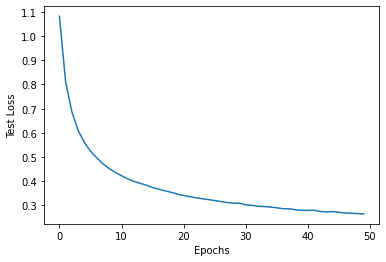

In [13]:
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.plot(losses[50:])
plt.show()

##Part 2
α=0.001 \\
BatchSize= 32 \\
Epochs= 50


In [20]:
model = MyNeuralModel(sizes=[784, 300, 200, 10], alpha=0.001,epochs=50)
batchsize=32
trainset = datasets.MNIST('./dataset/MNIST/', download=True, train=True, transform=transform)
testset = datasets.MNIST('./dataset/MNIST/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
dataloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True)
model.train(train_loader=trainloader, data_loader=dataloader)

Epoch: 1, Test Error Percent: 64.53, Loss: 2.16
Epoch: 2, Test Error Percent: 52.15, Loss: 1.66
Epoch: 3, Test Error Percent: 44.72, Loss: 1.40
Epoch: 4, Test Error Percent: 39.35, Loss: 1.23
Epoch: 5, Test Error Percent: 35.66, Loss: 1.12
Epoch: 6, Test Error Percent: 33.03, Loss: 1.03
Epoch: 7, Test Error Percent: 30.91, Loss: 0.97
Epoch: 8, Test Error Percent: 29.29, Loss: 0.91
Epoch: 9, Test Error Percent: 27.89, Loss: 0.87
Epoch: 10, Test Error Percent: 26.61, Loss: 0.83
Epoch: 11, Test Error Percent: 25.62, Loss: 0.80
Epoch: 12, Test Error Percent: 24.64, Loss: 0.77
Epoch: 13, Test Error Percent: 23.79, Loss: 0.75
Epoch: 14, Test Error Percent: 22.96, Loss: 0.72
Epoch: 15, Test Error Percent: 22.32, Loss: 0.70
Epoch: 16, Test Error Percent: 21.69, Loss: 0.68
Epoch: 17, Test Error Percent: 21.38, Loss: 0.67
Epoch: 18, Test Error Percent: 20.89, Loss: 0.65
Epoch: 19, Test Error Percent: 20.43, Loss: 0.64
Epoch: 20, Test Error Percent: 19.91, Loss: 0.63
Epoch: 21, Test Error Percent

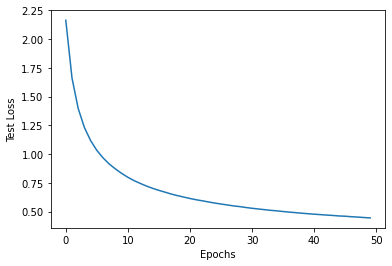

In [21]:
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.plot(losses[100:])
plt.show()

##Part 3
Implementing using all Pytorch functionalities
α=0.01, \\
BatchSize = 32, \\
Epochs = 50, \\
Initialised randomly between -1 and 1

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=200, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=200, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Epoch:  1
Running loss:  1.3554028755029042
Epoch:  2
Running loss:  0.6928444926659266
Epoch:  3
Running loss:  0.562808507768313
Epoch:  4
Running loss:  0.4957107708136241
Epoch:  5
Running loss:  0.4512089831550916
Epoch:  6
Running loss:  0.4184764657517274
Epoch:  7
Running loss:  0.3932140762925148
Epoch:  8
Running loss:  0.37243296249310176
Epoch:  9
Running loss:  0.355277185767889
Epoch:  10
Running loss:  0.34018190477093063
Epoch:  11
Running loss:  0.32685653550426164
Epoch:  12
Running loss:  0.31543459128340084
Epoch:  13
Running loss:  0.3048717051009337
Epoch:  14
Running loss:  0.2951209112405777
Epoch:  15
Running loss:  0.286456869584322
Epoch:  16
Running loss:  0.278391031173865
Epoch:  17
Running loss:  0.2707605313996474
Epoch:  18
Running loss:  0.263768940281868
Epoch:  19
Running loss:  0.25733603911697867
Epoch:  20
Running loss:  0.25110850722889105
Epoch:  21
Running loss:  0.2452757439762354
Epoch:  22
Running loss:  0.2399967335621516
Epoch:  23
Running

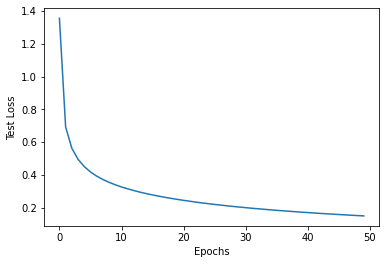

In [14]:

bsize=32
rate=0.01
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bsize, shuffle=True)

testset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=bsize, shuffle=True)

input_size = trainloader.dataset.train_data.shape[1] * trainloader.dataset.train_data.shape[2]
hidden_layers = [300,200]
output_size = 10

def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.uniform_(m.weight,-1.0,1.0)
    #torch.nn.init.zeros_(m.weight)


model = nn.Sequential(
    nn.Linear(input_size, hidden_layers[0]),
    nn.Sigmoid(),
    nn.Linear(hidden_layers[0], hidden_layers[1]),
    nn.Sigmoid(),
    nn.Linear(hidden_layers[1], output_size),
    nn.LogSoftmax(dim=1)
)
model.apply(init_weights)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=rate)

epochs = 50
lossesPy = []
for e in range(epochs):
    running_loss = 0
    for x, y in trainloader:
        
        x = x.view(x.shape[0], -1)
        
        # setting gradient to zeros
        optimizer.zero_grad()        
        output = model(x)
        loss = criterion(output, y)
        
        # backward propagation
        loss.backward()
        
        # update the gradient to new gradients
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch: ",e+1)
        print("Running loss: ",(running_loss/len(trainloader)))
        lossesPy.append(running_loss/len(trainloader))


correct=0
with torch.no_grad():
  for images,labels in testloader:
    logps = model(images.view(images.shape[0], -1))
    output = torch.squeeze(logps)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(labels.data.view_as(pred)).sum()
  print('\nAccuracy Percent: {}/{} ({:.0f})\n'.format(correct, len(testloader.dataset),
            100. * correct / len(testloader.dataset)))
  print('\nTest Error Percent: ({:.0f})\n'.format(100 - 100. * correct / len(testloader.dataset)))  

plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.plot(lossesPy)
plt.show()

α=0.01, \\
BatchSize = 64, \\
Epochs = 50, \\
Initialised randomly between -1 and 1

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=200, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=200, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch:  1
Running loss:  1.66600882276289
Epoch:  2
Running loss:  0.8988558681471261
Epoch:  3
Running loss:  0.7269050443032657
Epoch:  4
Running loss:  0.6378129174841493
Epoch:  5
Running loss:  0.5800781635873353
Epoch:  6
Running loss:  0.5391923740093134
Epoch:  7
Running loss:  0.506919973599377
Epoch:  8
Running loss:  0.4818153330512138
Epoch:  9
Running loss:  0.4604768698562437
Epoch:  10
Running loss:  0.4425029406733096
Epoch:  11
Running loss:  0.4264456866297132
Epoch:  12
Running loss:  0.412521428422633
Epoch:  13
Running loss:  0.40023032702934513
Epoch:  14
Running loss:  0.3889097477962722
Epoch:  15
Running loss:  0.37866832698776776
Epoch:  16
Running loss:  0.36928691026339655
Epoch:  17
Running loss:  0.3605873485

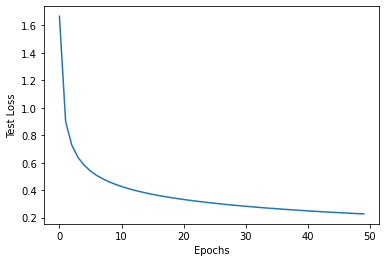

In [15]:

bsize=64
rate=0.01
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bsize, shuffle=True)

testset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=bsize, shuffle=True)

input_size = trainloader.dataset.train_data.shape[1] * trainloader.dataset.train_data.shape[2]
hidden_layers = [300,200]
output_size = 10

def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.uniform_(m.weight,-1.0,1.0)
    #torch.nn.init.zeros_(m.weight)


model = nn.Sequential(
    nn.Linear(input_size, hidden_layers[0]),
    nn.Sigmoid(),
    nn.Linear(hidden_layers[0], hidden_layers[1]),
    nn.Sigmoid(),
    nn.Linear(hidden_layers[1], output_size),
    nn.LogSoftmax(dim=1)
)
model.apply(init_weights)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=rate)

epochs = 50
lossesPy = []
for e in range(epochs):
    running_loss = 0
    for x, y in trainloader:
        
        x = x.view(x.shape[0], -1)
        
        # setting gradient to zeros
        optimizer.zero_grad()        
        output = model(x)
        loss = criterion(output, y)
        
        # backward propagation
        loss.backward()
        
        # update the gradient to new gradients
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch: ",e+1)
        print("Running loss: ",(running_loss/len(trainloader)))
        lossesPy.append(running_loss/len(trainloader))


correct=0
with torch.no_grad():
  for images,labels in testloader:
    logps = model(images.view(images.shape[0], -1))
    output = torch.squeeze(logps)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(labels.data.view_as(pred)).sum()
  print('\nAccuracy Percent: {}/{} ({:.0f})\n'.format(correct, len(testloader.dataset),
            100. * correct / len(testloader.dataset)))
  print('\nTest Error Percent: ({:.0f})\n'.format(100 - 100. * correct / len(testloader.dataset)))  

plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.plot(lossesPy)
plt.show()

α=0.001, \\
BatchSize = 32, \\
Epochs = 50, \\
Initialised randomly between -1 and 1

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=200, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=200, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch:  1
Running loss:  3.101777963638306
Epoch:  2
Running loss:  2.0181246898651124
Epoch:  3
Running loss:  1.6044015148162842
Epoch:  4
Running loss:  1.3743142185846964
Epoch:  5
Running loss:  1.2255228149731954
Epoch:  6
Running loss:  1.1196441295305888
Epoch:  7
Running loss:  1.0397201250553132
Epoch:  8
Running loss:  0.9765308330217998
Epoch:  9
Running loss:  0.924939005390803
Epoch:  10
Running loss:  0.8816284968852997
Epoch:  11
Running loss:  0.8447250290711721
Epoch:  12
Running loss:  0.8126930736621221
Epoch:  13
Running loss:  0.784514279460907
Epoch:  14
Running loss:  0.7596005520661672
Epoch:  15
Running loss:  0.7371003661950429
Epoch:  16
Running loss:  0.7169344770431518
Epoch:  17
Running loss:  0.698482823427

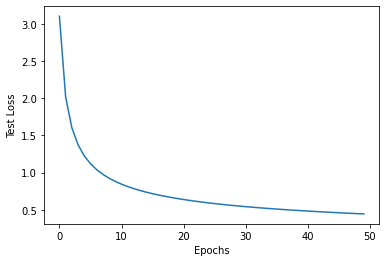

In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
# %matplotlib inline

bsize=32
rate=0.001
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bsize, shuffle=True)

testset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=bsize, shuffle=True)

input_size = trainloader.dataset.train_data.shape[1] * trainloader.dataset.train_data.shape[2]
hidden_layers = [300,200]
output_size = 10

def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.uniform_(m.weight,-1.0,1.0)
    #torch.nn.init.zeros_(m.weight)


model = nn.Sequential(
    nn.Linear(input_size, hidden_layers[0]),
    nn.Sigmoid(),
    nn.Linear(hidden_layers[0], hidden_layers[1]),
    nn.Sigmoid(),
    nn.Linear(hidden_layers[1], output_size),
    nn.LogSoftmax(dim=1)
)
model.apply(init_weights)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=rate)

epochs = 50
lossesPy = []
for e in range(epochs):
    running_loss = 0
    for x, y in trainloader:
        
        x = x.view(x.shape[0], -1)
        
        # setting gradient to zeros
        optimizer.zero_grad()        
        output = model(x)
        loss = criterion(output, y)
        
        # backward propagation
        loss.backward()
        
        # update the gradient to new gradients
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch: ",e+1)
        print("Running loss: ",(running_loss/len(trainloader)))
        lossesPy.append(running_loss/len(trainloader))


correct=0
with torch.no_grad():
  for images,labels in testloader:
    logps = model(images.view(images.shape[0], -1))
    output = torch.squeeze(logps)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(labels.data.view_as(pred)).sum()
  print('\nAccuracy Percent: {}/{} ({:.0f})\n'.format(correct, len(testloader.dataset),
            100. * correct / len(testloader.dataset)))
  print('\nTest Error Percent: ({:.0f})\n'.format(100 - 100. * correct / len(testloader.dataset)))  

plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.plot(lossesPy)
plt.show()

##Part 4
Initialising with 0


In [17]:
def pytorchzero(bsize,rate):
  transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ])
  trainset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=bsize, shuffle=True)

  testset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
  testloader = torch.utils.data.DataLoader(testset, batch_size=bsize, shuffle=True)

  input_size = trainloader.dataset.train_data.shape[1] * trainloader.dataset.train_data.shape[2]
  hidden_layers = [300,200]
  output_size = 10

  def init_weights(m):
    if type(m) == nn.Linear:
      #Initialise with zero
      torch.nn.init.zeros_(m.weight)


  model = nn.Sequential(
      nn.Linear(input_size, hidden_layers[0]),
      nn.Sigmoid(),
      nn.Linear(hidden_layers[0], hidden_layers[1]),
      nn.Sigmoid(),
      nn.Linear(hidden_layers[1], output_size),
      nn.LogSoftmax(dim=1)
  )
  model.apply(init_weights)
  print(model)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=rate)

  epochs = 50
  lossesPy = []
  for e in range(epochs):
      running_loss = 0
      for x, y in trainloader:
          
          x = x.view(x.shape[0], -1)
          
          # setting gradient to zeros
          optimizer.zero_grad()        
          output = model(x)
          loss = criterion(output, y)
          
          # backward propagation
          loss.backward()
          
          # update the gradient to new gradients
          optimizer.step()
          running_loss += loss.item()
      else:
          print("Epoch: ",e+1)
          print("Running loss: ",(running_loss/len(trainloader)))
          lossesPy.append(running_loss/len(trainloader))


  correct=0
  with torch.no_grad():
    for images,labels in testloader:
      logps = model(images.view(images.shape[0], -1))
      output = torch.squeeze(logps)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(labels.data.view_as(pred)).sum()
    print('\nAccuracy Percent: {}/{} ({:.0f})\n'.format(correct, len(testloader.dataset),
              100. * correct / len(testloader.dataset)))
    print('\nTest Error Percent: ({:.0f})\n'.format(100 - 100. * correct / len(testloader.dataset)))  

  plt.xlabel('Epochs')
  plt.ylabel('Test Loss')
  plt.plot(lossesPy)
  plt.show()

α=0.01, \\
BatchSize = 32, \\
Epochs = 50, \\
Initialised 0

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=200, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=200, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch:  1
Running loss:  2.3048077346801756
Epoch:  2
Running loss:  2.304574168395996
Epoch:  3
Running loss:  2.3046926727294923
Epoch:  4
Running loss:  2.3046489730834963
Epoch:  5
Running loss:  2.3046881247202555
Epoch:  6
Running loss:  2.3046422768910726
Epoch:  7
Running loss:  2.3043564044952394
Epoch:  8
Running loss:  2.3043295627593996
Epoch:  9
Running loss:  2.3039470049540203
Epoch:  10
Running loss:  2.3039905751546224
Epoch:  11
Running loss:  2.3039949993133546
Epoch:  12
Running loss:  2.3037372470855715
Epoch:  13
Running loss:  2.303827033106486
Epoch:  14
Running loss:  2.303802776845296
Epoch:  15
Running loss:  2.303231847381592
Epoch:  16
Running loss:  2.3032311510721843
Epoch:  17
Running loss:  2.3033901659647

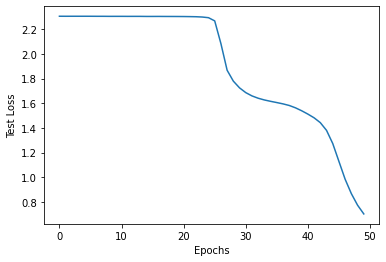

In [18]:
pytorchzero(32,0.01)

α=0.01, \\
BatchSize = 64, \\
Epochs = 50, \\
Initialised randomly 0

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=200, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=200, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch:  1
Running loss:  2.3031250322297185
Epoch:  2
Running loss:  2.3032819591859766
Epoch:  3
Running loss:  2.302950940406653
Epoch:  4
Running loss:  2.3028485658072206
Epoch:  5
Running loss:  2.302941116188635
Epoch:  6
Running loss:  2.3032541933344373
Epoch:  7
Running loss:  2.302838202224357
Epoch:  8
Running loss:  2.303013333379587
Epoch:  9
Running loss:  2.302973415805841
Epoch:  10
Running loss:  2.303191003260582
Epoch:  11
Running loss:  2.302792586243229
Epoch:  12
Running loss:  2.302983104293026
Epoch:  13
Running loss:  2.3028645520525446
Epoch:  14
Running loss:  2.3026620464792638
Epoch:  15
Running loss:  2.302853877356312
Epoch:  16
Running loss:  2.3026686144281805
Epoch:  17
Running loss:  2.303114694827147
Ep

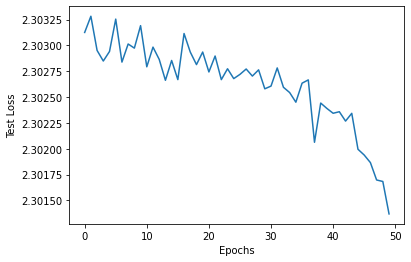

In [19]:
pytorchzero(64,0.01)